In [95]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

# Load Data

In [96]:
path = '../'

In [97]:
# promos = pd.read_csv(path + '/promos.csv.gz')
promos = pd.read_csv('promos.csv.gz')
promos.head()

,promo,category,promoqty,manufacturer,promoval,brand
0,209524,51006740,1,1593002228,1.00,189092190
1,176321,42760698,1,1957688344,0.75,1386413202
2,17125,56844954,1,629075831,1.50,1429623935
3,177412,56844954,1,629075831,1.50,1429623935
4,69839,56844954,1,629075831,1.50,1429623935


In [98]:
# train_history = pd.read_csv(path + '/train_history.csv.gz', parse_dates=['promodate'])
train_history = pd.read_csv('train_history.csv.gz', parse_dates=['promodate'])
train_history.head()

,id,store,promo,region,promodate,active
0,115562959531,860548,176321,243820,2013-03-25,0.0
1,175261390705,625933,37568,191747,2013-03-15,0.0
2,273751574633,527828,209524,165933,2013-03-23,1.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0
4,135410903443,241369,176321,278897,2013-03-25,0.0


In [99]:
train_history.promodate.max()

Timestamp('2013-03-31 00:00:00')

In [100]:
train_history.promodate.min()

Timestamp('2013-03-01 00:00:00')

In [101]:
train_history.isna().sum()

id           0
store        0
promo        0
region       0
promodate    0
active       0
dtype: int64

In [160]:
train_history.shape

(20000, 6)

In [102]:
train_history[train_history['active']==1]

,id,store,promo,region,promodate,active
2,273751574633,527828,209524,165933,2013-03-23,1.0
5,86374022367,740794,176321,203586,2013-03-28,1.0
11,22547995813,527828,209524,165933,2013-03-01,1.0
14,145640535386,252336,176321,191747,2013-03-26,1.0
17,207499271332,285434,37568,36431,2013-03-24,1.0
...,...,...,...,...,...,...
19981,224277409913,485613,176321,132336,2013-03-26,1.0
19983,195468314162,527828,209524,165933,2013-03-06,1.0
19989,167876595543,367489,108252,325318,2013-03-14,1.0
19992,235639710986,876095,176321,323706,2013-03-27,1.0


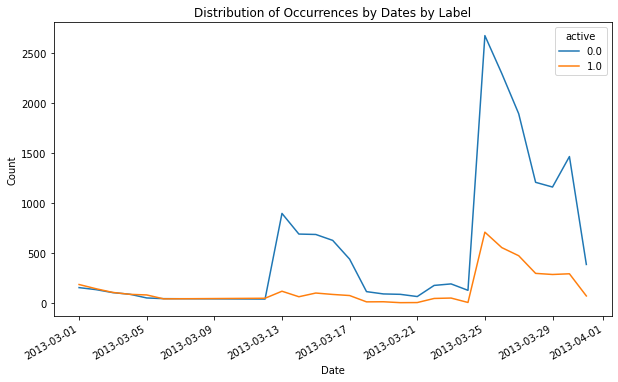

In [103]:
import matplotlib.pyplot as plt
counts = train_history.groupby(['promodate', 'active']).size().unstack(fill_value=0)
counts.plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Occurrences by Dates by Label')
plt.show()

In [104]:
# test_history = pd.read_csv(path + '/test_history.csv.gz', parse_dates=['promodate'])
test_history = pd.read_csv('test_history.csv.gz', parse_dates=['promodate'])
test_history.head()

,id,store,promo,region,promodate,active
0,250462324156,457755,96852,191747,2013-04-22,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN


In [105]:
test_history.promodate.max()

Timestamp('2013-04-30 00:00:00')

In [106]:
test_history.promodate.min()

Timestamp('2013-04-01 00:00:00')

In [107]:
transactions = pd.read_csv(path + 'transactions.csv.gz', parse_dates=['date'])
# transactions = pd.read_csv('transactions.csv.gz', parse_dates=['date'])
transactions.head()

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19


In [108]:
transactions.date.max()

Timestamp('2013-02-28 00:00:00')

In [109]:
transactions.date.min()

Timestamp('2012-03-02 00:00:00')

In [110]:
transactions.isna().sum()

id                   0
store                0
market_group         0
category             0
manufacturer         0
brand                0
date                 0
productsize          0
measure         971343
qty                  0
amt                  0
dtype: int64

In [111]:
transactions_month_test = transactions['date'].dt.month

In [112]:
train_trans_merged = train_history.merge(transactions, on='id', how='right')

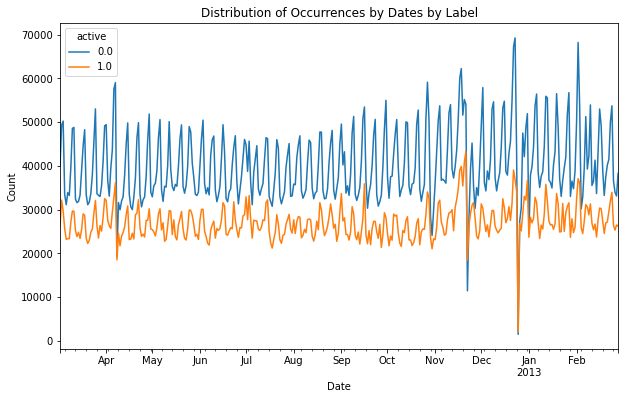

In [113]:
counts = train_trans_merged.groupby(['date', 'active']).size().unstack(fill_value=0)
counts.plot(kind='line', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Occurrences by Dates by Label')
plt.show()

# Feature Engineering

## Recent 3 months RFM

In [114]:
transactions_engineered = transactions.copy(deep=True)

In [115]:
start_date = transactions_engineered.date.max() - pd.DateOffset(months=3)
transactions_3_month = transactions_engineered[transactions_engineered['date'] >= start_date]

transactions_3_month['last_purchase_3_month'] = (transactions_engineered.date.max() - 
                                                 transactions_engineered['date']) / np.timedelta64(1, "D")

transactions_3_month_transf = transactions_3_month.groupby('id').agg({
    'last_purchase_3_month': 'min',
    'date': ['nunique', 'min'],
    'amt': 'sum',
})

C:\Users\jesse\AppData\Local\Temp\ipykernel_19624\3014052251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_3_month['last_purchase_3_month'] = (transactions_engineered.date.max() -


In [116]:
# Compute RFM columns
transactions_3_month_transf['recency_3_month'] = transactions_3_month_transf['last_purchase_3_month']['min']
transactions_3_month_transf['frequency_3_month'] = (transactions_3_month_transf['date']['nunique']
                               / ((transactions_engineered.date.max() - transactions_3_month_transf['date']['min']) / np.timedelta64(1, "D")))
transactions_3_month_transf['monetary_3_month'] = transactions_3_month_transf['amt']['sum']

# Select out required features
transactions_3_month_transf = transactions_3_month_transf[['recency_3_month', 'frequency_3_month', 'monetary_3_month']].reset_index()
transactions_3_month_transf.columns = transactions_3_month_transf.columns.get_level_values(0)
transactions_3_month_transf.head()

,id,recency_3_month,frequency_3_month,monetary_3_month
0,32159355,3.0,0.177778,842.61
1,38085541,4.0,0.159091,913.23
2,41697872,0.0,0.340909,1467.81
3,54676900,0.0,0.260870,516.98
4,58631253,0.0,0.315217,1646.55


In [117]:
transactions_3_month_transf.shape

(29971, 4)

## All RFM

In [118]:
transactions_engineered['last_purchase'] = (transactions_engineered.date.max() - 
                                 transactions_engineered['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
transactions_engineered_transf = transactions_engineered.groupby('id').agg({
    'last_purchase': 'min',
    'date': ['nunique', 'min'],
    'amt': 'sum',
})

# Compute RFM columns
transactions_engineered_transf['recency'] = transactions_engineered_transf['last_purchase']['min']
transactions_engineered_transf['frequency'] = (transactions_engineered_transf['date']['nunique']
                               / ((transactions_engineered.date.max() - transactions_engineered_transf['date']['min']) / np.timedelta64(1, "D")))
transactions_engineered_transf['monetary'] = transactions_engineered_transf['amt']['sum']

# Select out required features
transactions_engineered_transf = transactions_engineered_transf[['recency', 'frequency', 'monetary']].reset_index()
transactions_engineered_transf.columns = transactions_engineered_transf.columns.get_level_values(0)
transactions_engineered_transf.head()

,id,recency,frequency,monetary
0,32159355,3.0,0.201117,3141.84
1,38085541,4.0,0.146814,2231.17
2,41697872,0.0,0.248619,5006.52
3,54676900,0.0,0.245810,1793.02
4,58631253,0.0,0.251381,4926.40


In [119]:
transactions_engineered_transf.shape

(29988, 4)

## Count Brand and Category

In [120]:
transactions_cat_count = transactions_engineered.groupby(['id', 'category']).count()[['store']]
transactions_cat_count = transactions_cat_count.reset_index()
transactions_cat_count.columns = ['id', 'category', 'category_count']
transactions_cat_count['category'] = transactions_cat_count['category'].astype(int)
transactions_cat_count.head()

,id,category,category_count
0,32159355,56797,1
1,32159355,201779,2
2,32159355,472968,3
3,32159355,1125818,8
4,32159355,1281213,1


In [121]:
transactions_brand_count = transactions_engineered.groupby(['id', 'brand']).count()[['store']]
transactions_brand_count = transactions_brand_count.reset_index()
transactions_brand_count.columns = ['id', 'brand', 'brand_count']
transactions_brand_count['brand'] = transactions_brand_count['brand'].astype('int64')
transactions_brand_count.head()

,id,brand,brand_count
0,32159355,8570994,1
1,32159355,32146788,2
2,32159355,33392255,2
3,32159355,39333655,1
4,32159355,41563264,1


## Join History and Promo and Feature Engineering

In [122]:
train_promo_merged = pd.merge(train_history, promos, how='left', on='promo')
train_promo_merged.head()

,id,store,promo,region,promodate,active,category,promoqty,manufacturer,promoval,brand
0,115562959531,860548,176321,243820,2013-03-25,0.0,42760698,1,1957688344,0.75,1386413202
1,175261390705,625933,37568,191747,2013-03-15,0.0,75228190,1,1154816776,2.00,1234009542
2,273751574633,527828,209524,165933,2013-03-23,1.0,51006740,1,1593002228,1.00,189092190
3,166923268906,1056730,214816,5506,2013-03-20,0.0,8946099,1,1150283635,2.00,86145108
4,135410903443,241369,176321,278897,2013-03-25,0.0,42760698,1,1957688344,0.75,1386413202


In [123]:
train_promo_merged = pd.merge(train_promo_merged, transactions_cat_count, how='left', on=['id', 'category'])
train_promo_merged.head()

,id,store,promo,region,promodate,active,category,promoqty,manufacturer,promoval,brand,category_count
0,115562959531,860548,176321,243820,2013-03-25,0.0,42760698,1,1957688344,0.75,1386413202,1.0
1,175261390705,625933,37568,191747,2013-03-15,0.0,75228190,1,1154816776,2.00,1234009542,NaN
2,273751574633,527828,209524,165933,2013-03-23,1.0,51006740,1,1593002228,1.00,189092190,3.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0,8946099,1,1150283635,2.00,86145108,2.0
4,135410903443,241369,176321,278897,2013-03-25,0.0,42760698,1,1957688344,0.75,1386413202,NaN


In [124]:
train_promo_merged = pd.merge(train_promo_merged, transactions_brand_count, how='left', on=['id', 'brand'])
train_promo_merged.head()

,id,store,promo,region,promodate,active,category,promoqty,manufacturer,promoval,brand,category_count,brand_count
0,115562959531,860548,176321,243820,2013-03-25,0.0,42760698,1,1957688344,0.75,1386413202,1.0,NaN
1,175261390705,625933,37568,191747,2013-03-15,0.0,75228190,1,1154816776,2.00,1234009542,NaN,35.0
2,273751574633,527828,209524,165933,2013-03-23,1.0,51006740,1,1593002228,1.00,189092190,3.0,NaN
3,166923268906,1056730,214816,5506,2013-03-20,0.0,8946099,1,1150283635,2.00,86145108,2.0,2.0
4,135410903443,241369,176321,278897,2013-03-25,0.0,42760698,1,1957688344,0.75,1386413202,NaN,NaN


In [125]:
# train_promo_merged['dow'] = train_promo_merged['promodate'].dt.dayofweek
# train_promo_merged.head()

In [126]:
train_promo_merged.drop(['manufacturer', 'brand', 'promodate', 'promoqty', 'category'], axis=1, inplace=True)
train_promo_merged.head()

,id,store,promo,region,active,promoval,category_count,brand_count
0,115562959531,860548,176321,243820,0.0,0.75,1.0,NaN
1,175261390705,625933,37568,191747,0.0,2.00,NaN,35.0
2,273751574633,527828,209524,165933,1.0,1.00,3.0,NaN
3,166923268906,1056730,214816,5506,0.0,2.00,2.0,2.0
4,135410903443,241369,176321,278897,0.0,0.75,NaN,NaN


In [127]:
train_promo_merged.dtypes

id                  int64
store               int64
promo               int64
region              int64
active            float64
promoval          float64
category_count    float64
brand_count       float64
dtype: object

## OneHotEncode Train

In [128]:
# cat_list = ['store', 'promo', 'region', 'dow']
cat_list = ['store', 'promo', 'region']

In [129]:
for cat in cat_list:
    train_promo_merged[cat] = train_promo_merged[cat].astype(str)
train_promo_merged.dtypes

id                  int64
store              object
promo              object
region             object
active            float64
promoval          float64
category_count    float64
brand_count       float64
dtype: object

In [130]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_data = enc.fit_transform(train_promo_merged[cat_list]).toarray()
enc_df = pd.DataFrame(enc_data, columns=enc.get_feature_names())

train_merged_onehot_df = pd.concat([train_promo_merged, enc_df], axis=1)
train_merged_onehot_df.head()

C:\Users\jesse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,id,store,promo,region,active,promoval,category_count,brand_count,x0_1020264,x0_1026678,...,x2_334402,x2_36431,x2_36835,x2_42449,x2_42773,x2_48013,x2_5506,x2_62416,x2_67664,x2_7892
0,115562959531,860548,176321,243820,0.0,0.75,1.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,175261390705,625933,37568,191747,0.0,2.00,NaN,35.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,273751574633,527828,209524,165933,1.0,1.00,3.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,166923268906,1056730,214816,5506,0.0,2.00,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,135410903443,241369,176321,278897,0.0,0.75,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
train_merged_onehot_df.drop(cat_list, axis=1, inplace=True)
train_merged_onehot_df.head()

,id,active,promoval,category_count,brand_count,x0_1020264,x0_1026678,x0_1027597,x0_1050704,x0_1053332,...,x2_334402,x2_36431,x2_36835,x2_42449,x2_42773,x2_48013,x2_5506,x2_62416,x2_67664,x2_7892
0,115562959531,0.0,0.75,1.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,175261390705,0.0,2.00,NaN,35.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,273751574633,1.0,1.00,3.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,166923268906,0.0,2.00,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,135410903443,0.0,0.75,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Extract Features

## Generate train, test and prediction sets

In [132]:
seed = 84

In [133]:
transactions_3_month_transf.columns

Index(['id', 'recency_3_month', 'frequency_3_month', 'monetary_3_month'], dtype='object')

In [134]:
# Generate train/test features
features = train_merged_onehot_df.merge(transactions_engineered_transf, on='id', how='left')
features = features.merge(transactions_3_month_transf, on='id', how='left')
features.recency.fillna(365, inplace=True)
features.frequency.fillna(0, inplace=True)
features.monetary.fillna(0, inplace=True)
features.recency_3_month.fillna(90, inplace=True)
features.frequency_3_month.fillna(0, inplace=True)
features.monetary_3_month.fillna(0, inplace=True)
features.category_count.fillna(0, inplace=True)
features.brand_count.fillna(0, inplace=True)


features.head()

,id,active,promoval,category_count,brand_count,x0_1020264,x0_1026678,x0_1027597,x0_1050704,x0_1053332,...,x2_5506,x2_62416,x2_67664,x2_7892,recency,frequency,monetary,recency_3_month,frequency_3_month,monetary_3_month
0,115562959531,0.0,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.150000,2697.93,0.0,0.163043,788.78
1,175261390705,0.0,2.00,0.0,35.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,13.0,0.086835,1938.51,13.0,0.114943,713.86
2,273751574633,1.0,1.00,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.069277,420.44,6.0,0.065217,91.27
3,166923268906,0.0,2.00,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.212885,3823.56,1.0,0.388889,1782.19
4,135410903443,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.146409,3787.26,2.0,0.133333,901.13


In [161]:
features.to_csv('feature.csv')

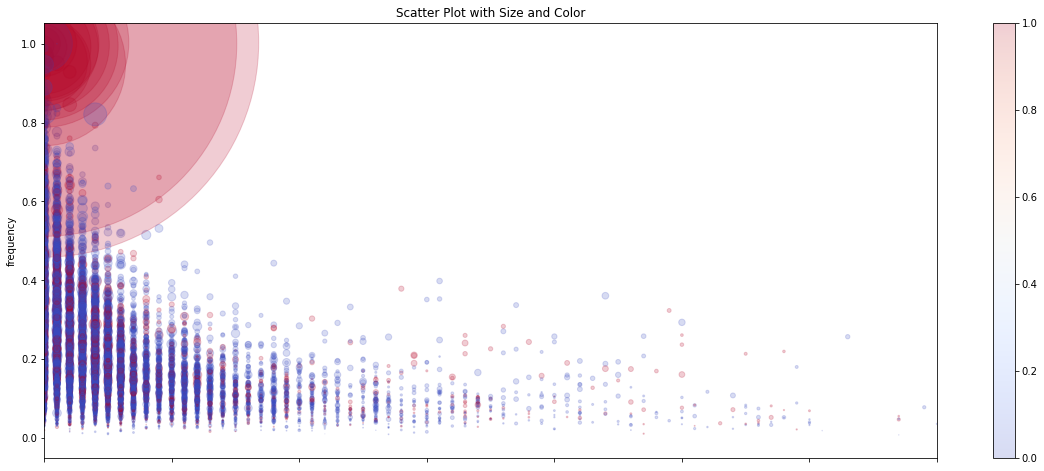

In [157]:
ax = features[['active', 'recency', 'frequency', 'monetary']].plot.scatter(x='recency', 
                                                                         y='frequency', 
                                                                         s=features['monetary']/150, 
                                                                         c=features['active'], 
                                                                         cmap='coolwarm', alpha=0.2, figsize=(20,8))

# Add a colorbar to the plot
# plt.colorbar(ax.collections[0])

plt.xlim(0, 70)

# Add axis labels and a title to the plot
plt.xlabel('recency')
plt.ylabel('frequency')
plt.title('Scatter Plot with Size and Color')

# Display the plot
plt.show()

In [43]:
x_cols = features.columns.to_list()
x_cols.remove('active')
x_cols.remove('id')
y_col = 'active'

X = features[x_cols]
y = features[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)

## Oversampling

In [44]:
# oversampler = RandomOverSampler()
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [45]:
# smote = SMOTE(random_state=seed)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Build Model

In [46]:
param_grid = {
    'n_estimators': [800],
    'max_depth': [20],
    'min_samples_split': [10],
    'min_samples_leaf': [4]
}

In [47]:
# param_grid = {
#     'n_estimators': [100, 200, 500, 800],
#     'max_depth': [5, 10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4, 8]
# }

In [48]:
rfc = RandomForestClassifier(random_state=seed)
grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=84), n_jobs=-1,
             param_grid={'max_depth': [20], 'min_samples_leaf': [4],
                         'min_samples_split': [10], 'n_estimators': [800]},
             scoring='roc_auc')

In [49]:
best_rfc = grid_search.best_estimator_
y_pred = best_rfc.predict_proba(X_test)[:, 1]
# y_pred = best_rfc.predict(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

In [50]:
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'AUC on test set: {auc:.2f}')

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 800}
AUC on test set: 0.69


In [89]:
# Get the feature importances
importances = best_rfc.feature_importances_

importance_df = X_train.head(1).T
importance_df['importance'] = importances
importance_df.drop(16418, axis=1, inplace = True)
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df.head(10)

,importance
monetary,0.098367
monetary_3_month,0.097044
x1_209524,0.094442
frequency,0.086450
frequency_3_month,0.083279
category_count,0.072366
promoval,0.056640
x0_527828,0.052525
recency_3_month,0.045128
recency,0.044519


In [162]:
importance_df.to_csv('importance.csv')

<AxesSubplot:>

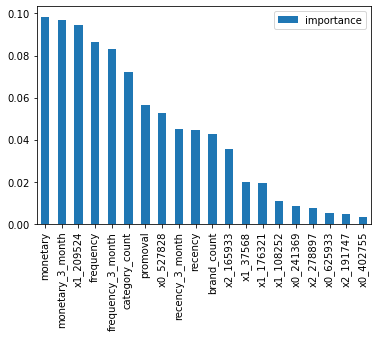

In [91]:
importance_df.head(20).plot(kind='bar')

In [52]:
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [53]:
# print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
# print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, y_pred)))

# Predict

In [54]:
test_promo_merged = pd.merge(test_history, promos, how='left', on='promo')
test_promo_merged.head()

,id,store,promo,region,promodate,active,category,promoqty,manufacturer,promoval,brand
0,250462324156,457755,96852,191747,2013-04-22,NaN,79950300,1,107216507,1.0,649187428
1,61214568335,740794,54956,203586,2013-04-23,NaN,59128902,1,122801592,2.0,704691081
2,274776763999,394092,95011,42773,2013-04-02,NaN,51006740,1,2037186963,1.0,854156277
3,91546215019,876095,108237,323706,2013-04-24,NaN,17240091,1,376504989,1.0,2395929821
4,220718580189,625933,222088,191747,2013-04-18,NaN,75536470,1,266826345,1.5,1893579944


In [55]:
test_promo_merged = pd.merge(test_promo_merged, transactions_cat_count, how='left', on=['id', 'category'])
test_promo_merged.head()

,id,store,promo,region,promodate,active,category,promoqty,manufacturer,promoval,brand,category_count
0,250462324156,457755,96852,191747,2013-04-22,NaN,79950300,1,107216507,1.0,649187428,11.0
1,61214568335,740794,54956,203586,2013-04-23,NaN,59128902,1,122801592,2.0,704691081,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN,51006740,1,2037186963,1.0,854156277,9.0
3,91546215019,876095,108237,323706,2013-04-24,NaN,17240091,1,376504989,1.0,2395929821,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN,75536470,1,266826345,1.5,1893579944,1.0


In [56]:
test_promo_merged = pd.merge(test_promo_merged, transactions_brand_count, how='left', on=['id', 'brand'])
test_promo_merged.head()

,id,store,promo,region,promodate,active,category,promoqty,manufacturer,promoval,brand,category_count,brand_count
0,250462324156,457755,96852,191747,2013-04-22,NaN,79950300,1,107216507,1.0,649187428,11.0,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN,59128902,1,122801592,2.0,704691081,NaN,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN,51006740,1,2037186963,1.0,854156277,9.0,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN,17240091,1,376504989,1.0,2395929821,NaN,9.0
4,220718580189,625933,222088,191747,2013-04-18,NaN,75536470,1,266826345,1.5,1893579944,1.0,NaN


In [57]:
# test_promo_merged['dow'] = test_promo_merged['promodate'].dt.dayofweek
# test_promo_merged.head()

In [58]:
test_promo_merged.drop(['manufacturer', 'brand', 'promodate', 'promoqty', 'category'], axis=1, inplace=True)
test_promo_merged.head()

,id,store,promo,region,active,promoval,category_count,brand_count
0,250462324156,457755,96852,191747,NaN,1.0,11.0,NaN
1,61214568335,740794,54956,203586,NaN,2.0,NaN,NaN
2,274776763999,394092,95011,42773,NaN,1.0,9.0,NaN
3,91546215019,876095,108237,323706,NaN,1.0,NaN,9.0
4,220718580189,625933,222088,191747,NaN,1.5,1.0,NaN


In [59]:
test_promo_merged.dtypes

id                  int64
store               int64
promo               int64
region              int64
active            float64
promoval          float64
category_count    float64
brand_count       float64
dtype: object

In [60]:
# cat_list = ['store', 'promo', 'region', 'dow']
cat_list = ['store', 'promo', 'region']

In [61]:
for cat in cat_list:
    test_promo_merged[cat] = test_promo_merged[cat].astype(str)
test_promo_merged.dtypes

id                  int64
store              object
promo              object
region             object
active            float64
promoval          float64
category_count    float64
brand_count       float64
dtype: object

In [62]:
enc_data = enc.transform(test_promo_merged[cat_list]).toarray()
enc_df = pd.DataFrame(enc_data, columns=enc.get_feature_names())

test_merged_onehot_df = pd.concat([test_promo_merged, enc_df], axis=1)
test_merged_onehot_df.head()

C:\Users\jesse\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,id,store,promo,region,active,promoval,category_count,brand_count,x0_1020264,x0_1026678,...,x2_334402,x2_36431,x2_36835,x2_42449,x2_42773,x2_48013,x2_5506,x2_62416,x2_67664,x2_7892
0,250462324156,457755,96852,191747,NaN,1.0,11.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,61214568335,740794,54956,203586,NaN,2.0,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,274776763999,394092,95011,42773,NaN,1.0,9.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,91546215019,876095,108237,323706,NaN,1.0,NaN,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,220718580189,625933,222088,191747,NaN,1.5,1.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
test_merged_onehot_df.drop(cat_list, axis=1, inplace=True)
test_merged_onehot_df.head()

,id,active,promoval,category_count,brand_count,x0_1020264,x0_1026678,x0_1027597,x0_1050704,x0_1053332,...,x2_334402,x2_36431,x2_36835,x2_42449,x2_42773,x2_48013,x2_5506,x2_62416,x2_67664,x2_7892
0,250462324156,NaN,1.0,11.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,61214568335,NaN,2.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,274776763999,NaN,1.0,9.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,91546215019,NaN,1.0,NaN,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,220718580189,NaN,1.5,1.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Generate train/test features
predict_features = test_merged_onehot_df.merge(transactions_engineered_transf, on='id', how='left')
predict_features = predict_features.merge(transactions_3_month_transf, on='id', how='left')
predict_features.recency.fillna(365, inplace=True)
predict_features.frequency.fillna(0, inplace=True)
predict_features.monetary.fillna(0, inplace=True)
predict_features.recency_3_month.fillna(90, inplace=True)
predict_features.frequency_3_month.fillna(0, inplace=True)
predict_features.monetary_3_month.fillna(0, inplace=True)
predict_features.category_count.fillna(0, inplace=True)
predict_features.brand_count.fillna(0, inplace=True)

predict_features.head()

,id,active,promoval,category_count,brand_count,x0_1020264,x0_1026678,x0_1027597,x0_1050704,x0_1053332,...,x2_5506,x2_62416,x2_67664,x2_7892,recency,frequency,monetary,recency_3_month,frequency_3_month,monetary_3_month
0,250462324156,NaN,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.312155,7346.62,1.0,0.352273,2082.09
1,61214568335,NaN,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.630854,2845.80,2.0,0.626374,821.45
2,274776763999,NaN,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.351124,1791.99,5.0,0.444444,560.38
3,91546215019,NaN,1.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.280992,3661.45,0.0,0.351648,1398.66
4,220718580189,NaN,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.400552,3093.23,0.0,0.467391,908.57


In [65]:
X_predict = predict_features[x_cols]
predict_out = predict_features[['id', 'active']].copy()

In [66]:
predict_out.head()

,id,active
0,250462324156,NaN
1,61214568335,NaN
2,274776763999,NaN
3,91546215019,NaN
4,220718580189,NaN


In [67]:
pred_rfc = RandomForestClassifier(random_state=seed,
                                     n_estimators=800,
                                    max_depth=20,
                                    min_samples_split=10,
                                    min_samples_leaf=4)
pred_rfc.fit(X, y)
predict_out['active'] = pred_rfc.predict_proba(X_predict)[:, 1]
predict_out.head()

,id,active
0,250462324156,0.296358
1,61214568335,0.140425
2,274776763999,0.285910
3,91546215019,0.282550
4,220718580189,0.170204


In [68]:
predict_out.to_csv('predict.csv', header=True, index=False)
predict_out.head()

,id,active
0,250462324156,0.296358
1,61214568335,0.140425
2,274776763999,0.285910
3,91546215019,0.282550
4,220718580189,0.170204
